### Processing

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
path = "/content/drive/My Drive/M2/DR"

import sys
sys.path.append(path)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
from math import sqrt

datasets = {}

#################################################
# Dataset
#################################################

def add_dataset(X_train, y_train, X_test, y_test, dataset_name):
    min_X = min(X_train.min(), X_test.min())
    max_X = max(X_train.max(), X_test.max())
    X_train, X_test = (X_train - min_X) / (max_X - min_X), (X_test - min_X) / (max_X - min_X)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    datasets[dataset_name] = (X_train, y_train, X_test, y_test)  
    print(dataset_name)     
    print(X_train.min())
    print(X_train.max())
    print(X_train.shape)
    print(X_test.shape)

# MNIST
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
add_dataset(X_test, y_test, X_train, y_train, "MNIST")

# USPS
mat = io.loadmat(path+"/Images_Datasets/USPS.mat")
X_train = X_test = mat['X'].reshape( (mat['X'].shape[0], int(sqrt(mat['X'].shape[1])), int(sqrt(mat['X'].shape[1]))) )
y_train = y_test = mat['y']
add_dataset(X_train, y_train, X_test, y_test, "USPS")   

# COIL 20
mat = io.loadmat(path+"/Images_Datasets/coil_20.mat")
mat['X'] = np.array(mat['X'].todense())
X_train = X_test = mat['X'].reshape( (mat['X'].shape[0], int(sqrt(mat['X'].shape[1])), int(sqrt(mat['X'].shape[1]))) )
y_train = y_test = np.repeat(np.arange(20), 72)
add_dataset(X_train, y_train, X_test, y_test, "COIL-20")   

# COIL 100
mat = io.loadmat(path+"/Images_Datasets/coil_100.mat")
mat['X'] = np.array(mat['X'].todense())
X_train = X_test = mat['X'].reshape( (mat['X'].shape[0], int(sqrt(mat['X'].shape[1])), int(sqrt(mat['X'].shape[1]))) )
y_train = y_test = np.repeat(np.arange(100), 72)
add_dataset(X_train, y_train, X_test, y_test, "COIL-100")   

# ORL
mat = io.loadmat(path+"/Images_Datasets/orl.mat")
mat['X'] = np.array(mat['X'].todense())
X_train = X_test = mat['X'].reshape( (mat['X'].shape[0], 112, 92) )
y_train = y_test = np.repeat(np.arange(40), 10)
add_dataset(X_train, y_train, X_test, y_test, "ORL")   


#################################################
# Functions
#################################################
num_examples_to_generate=16
def plot_images(predictions, epoch):
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  plot_images(predictions, epoch)

Using TensorFlow backend.


MNIST
0.0
1.0
(10000, 28, 28, 1)
(60000, 28, 28, 1)
USPS
0.0
1.0
(9298, 16, 16, 1)
(9298, 16, 16, 1)
COIL-20
0.0
1.0
(1440, 128, 128, 1)
(1440, 128, 128, 1)
COIL-100
0.0
1.0
(7200, 128, 128, 1)
(7200, 128, 128, 1)
ORL
0.0
1.0
(400, 112, 92, 1)
(400, 112, 92, 1)


In [0]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

X, y, _, _ = datasets["MNIST"]

gmm = GaussianMixture(n_components=len(np.unique(y)), n_init=20, max_iter=300, verbose=1)
label = gmm.fit_predict(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))

res_nmi = nmi(label, y)
res_ari = ari(label, y)       
print(res_nmi)
print(res_ari)

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

X_train, y_train, _, _ = datasets["MNIST"]

kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))

print(nmi(kmeans.labels_, y_train))
print(ari(kmeans.labels_, y_train))

## **1. Deep Autoencoder**

### Model

In [0]:
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 100
batch_size = 256

encoding_dim = 7*7
hidden_dim = 512

#activation='elu'
activation='leaky_relu'
optimizer='adam'
#loss='mean_squared_error'
loss='binary_crossentropy'
#################################################

out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
activation = None if activation=='leaky_relu' else activation

def make_autoencoder_model():
    #################################################
    # Auto-encoder
    #################################################
    input_img = Input(shape=(784,))


    ####### Encoder #######
    #   Layer
    encoded = Dense(hidden_dim, activation=activation)(input_img)
    if activation is None: encoded = layers.LeakyReLU()(encoded)

    #   Layer
    encoded = Dense(hidden_dim//4, activation=activation)(encoded)
    if activation is None: encoded = layers.LeakyReLU()(encoded)

    #   Layer
    encoded = Dense(encoding_dim, activation=out_activation)(encoded)


    ####### Decoder #######
    #   Layer
    decoded = Dense(hidden_dim//4, activation=activation)(encoded)
    if activation is None: decoded = layers.LeakyReLU()(decoded)

    #   Layer
    decoded = Dense(hidden_dim, activation=activation)(decoded)
    if activation is None: decoded = layers.LeakyReLU()(decoded)

    #   Layer
    decoded = Dense(784, activation=out_activation)(decoded)


    ####### Make model #######
    autoencoder = Model(input_img, decoded)

    return autoencoder

### Training

In [0]:

autoencoder = make_autoencoder_model()
autoencoder.compile(optimizer=optimizer, loss=loss)
autoencoder.summary()
####### Train #######
autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))


####### Encode images #######
encoder = Model(input_img, encoded)
encoded_images = encoder.predict(X_train)
#################################################



#################################################
# KMeans
#################################################
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, y_train))
print(ari(kmeans.labels_, y_train))
#################################################

## **2. Deep Convolutional Autoencoder**

### Model

In [0]:
from tensorflow import keras
from tensorflow.keras import Input, layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from math import sqrt

nmi = normalized_mutual_info_score
ari = adjusted_rand_score



#################################################
# Hyper-parameters
#################################################
epoch = 10
batch_size = 256

#activation='elu'
activation='leaky_relu'
optimizer='adam'
#loss='mean_squared_error'
loss='binary_crossentropy'
num_conv=1

use_batch_norm_encoded = False
use_batch_norm_decoded = False
#################################################

out_activation = 'sigmoid' if loss=='binary_crossentropy' else 'linear'
activation = None if activation=='leaky_relu' else activation


def conv_layer(input_tensor, filters=32, kernel=(3,3), strides=1, 
               activation="relu", use_batch_norm=False, padding='valid'):
  out = layers.Conv2D(filters, kernel, strides=strides, activation=activation, padding=padding)(input_tensor)
  if use_batch_norm:     out = layers.BatchNormalization()(out)
  if activation is None: out = layers.LeakyReLU()(out)
  return out

def deconv_layer(input_tensor, filters=32, kernel=(3,3), strides=1, 
                 activation="relu", use_batch_norm=False, padding='valid'):
  out = layers.Conv2DTranspose(filters, kernel, strides=strides, activation=activation, padding=padding)(input_tensor)
  if use_batch_norm:     out = layers.BatchNormalization()(out)
  if activation is None: out = layers.LeakyReLU()(out)
  return out


def make_conv_autoencoder_parameters(img_height=28, img_width=28, num_conv=num_conv):
    big_img = img_height >= 18 and img_width >= 18       # MNIST
    orl_img = img_height >= 64 and img_width >= 64       # ORL
    big_big_img = img_height >= 100 and img_width >= 100 # COIL-20, COIL-100

    divisor = 8 if big_big_img else 4 if big_img else 2
    encoding_height, encoding_width = img_height//divisor, img_width//divisor
    encoding_dim = encoding_height * encoding_width
    encoding_dim = encoding_height//2 * encoding_width//2 if not big_big_img and orl_img else encoding_dim
    num_conv = 2 if big_big_img or orl_img else 1
    filters = 8 if big_big_img else 32

    return big_img, orl_img, big_big_img, encoding_height, encoding_width, \
        encoding_dim, num_conv, filters

def make_conv_autoencoder_model(img_height=28, img_width=28, num_conv=num_conv):

  # Change architecture according to the data set
  big_img, orl_img, big_big_img, encoding_height, encoding_width, \
      encoding_dim, num_conv, filters = make_conv_autoencoder_parameters(img_height, img_width, num_conv)

  #################################################
  # Convolutional Auto-encoder
  #################################################
  input_img = Input((img_height, img_width, 1))

  ####### Encoder #######
  encoded = input_img
  #   Layer
  for i in range(num_conv):
      encoded = conv_layer(encoded, filters=filters, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_encoded,
                          padding='same') 
      if (big_big_img or orl_img) and i < 1: encoded = layers.MaxPooling2D((2, 2))(encoded)  
  encoded = layers.MaxPooling2D((2, 2))(encoded)

  #   Layer
  for i in range(num_conv):
      encoded = conv_layer(encoded, filters=filters*2, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_encoded,
                          padding='same')  
      if (big_big_img or orl_img) and i < 1: encoded = layers.MaxPooling2D((2, 2))(encoded) 
  encoded = layers.MaxPooling2D((2, 2))(encoded) 

  #   Layer
  to_sub = 1 if big_img else 0
  for i in range(num_conv-to_sub):
      encoded = conv_layer(encoded, filters=64, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_encoded,
                          padding='same')
      #if big_big_img  and i < 1: encoded = layers.MaxPooling2D((2, 2))(encoded) 
  if big_img:
      #padding = 'same' if big_big_img else 'valid'
      padding = 'valid'
      encoded = conv_layer(encoded, filters=64, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_encoded,
                           padding=padding)
      if big_big_img: encoded = layers.MaxPooling2D((2, 2))(encoded) 

  #   Layer
  encoded = layers.Flatten()(encoded)
  encoded = layers.Dense(encoding_dim, activation=out_activation)(encoded)


  ####### Decoder #######
  decoded_input = encoded if encoding_dim == encoding_height * encoding_width else layers.Dense(encoding_height * encoding_width)(encoded)
  decoded = layers.Reshape((encoding_height, encoding_width, 1))(decoded_input)

  #   Layer
  #if big_big_img: filters = filters // 2
  strides = 2 if big_big_img else 1  
  decoded = deconv_layer(decoded, filters=filters*4, kernel=(3,3), strides=strides, 
                         activation=activation, use_batch_norm=use_batch_norm_decoded,
                         padding='same')
  for _ in range(num_conv-1):
      decoded = deconv_layer(decoded, filters=filters*4, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_decoded,
                          padding='same')

  #   Layer
  decoded = deconv_layer(decoded, filters=filters*2, kernel=(3,3), strides=2, 
                         activation=activation, use_batch_norm=use_batch_norm_decoded,
                         padding='same')  
  for _ in range(num_conv-1):
      decoded = deconv_layer(decoded, filters=filters*2, kernel=(3,3), strides=1, 
                          activation=activation, use_batch_norm=use_batch_norm_decoded,
                          padding='same')

  #   Layer
  strides = 2 if big_img else 1
  decoded = deconv_layer(decoded, filters=filters, kernel=(3,3), strides=strides, 
                            activation=activation, use_batch_norm=use_batch_norm_decoded,
                            padding='same')
  for _ in range(num_conv-1):
      decoded = deconv_layer(decoded, filters=filters, kernel=(3,3), strides=1, 
                            activation=activation, use_batch_norm=use_batch_norm_decoded,
                            padding='same')

  #   Layer
  decoded = layers.Conv2D(1, (3, 3), activation=out_activation, padding='same')(decoded)


  ####### Make model #######
  autoencoder = models.Model(input_img, decoded)
  encoder = models.Model(input_img, encoded)
  #decoder = models.Model(encoded, decoded)
  autoencoder.compile(loss=loss, optimizer=optimizer)

  return autoencoder, encoder, decoded

### Training

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
leaky_re_lu_228 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
leaky_re_lu_229 (LeakyReLU)  (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 32, 32, 8)         0  

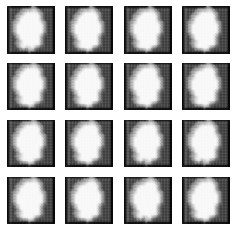

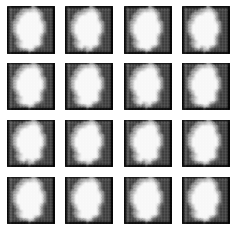

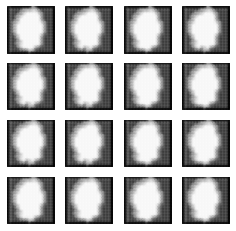

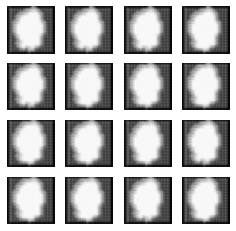

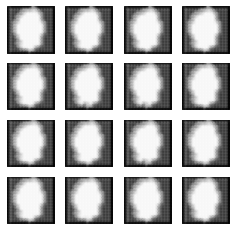

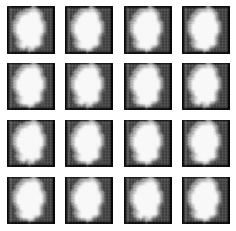

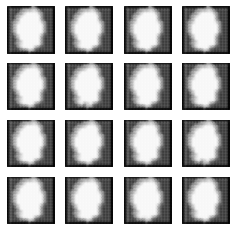

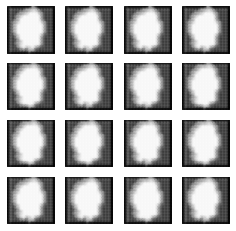

(1440, 256)
run KMeans
0.3610683193496406
0.08862237449117111


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [37]:
epoch = 50

import os
import tensorflow as tf

#X_train, y_train, X_test, y_test = datasets["MNIST"]
#X_test, y_test, X_train, y_train = datasets["MNIST"]
X_train, y_train, X_test, y_test = datasets["USPS"]
X_train, y_train, X_test, y_test = datasets["COIL-20"]
#X_train, y_train, X_test, y_test = datasets["ORL"]

autoencoder, encoder, decoded = make_conv_autoencoder_model(X_train.shape[1], X_train.shape[2])
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

"""ae_checkpoint_dir = path+'/ae_training_checkpoints'
ae_checkpoint_prefix = os.path.join(ae_checkpoint_dir, "ckpt")
ae_checkpoint = tf.train.Checkpoint(autoencoder=autoencoder)

ae_checkpoint.restore(tf.train.latest_checkpoint(ae_checkpoint_dir))"""

"""for _ in range(8):
  generate_and_save_images(autoencoder, 0, 
                        test_input=X_train[np.random.randint(low=0,high=train_images.shape[0],size=16)])"""

####### Train #######
autoencoder.fit(X_train, X_train,
                epochs=epoch,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test))

#ae_checkpoint.save(file_prefix = ae_checkpoint_prefix)

for _ in range(8):
  generate_and_save_images(autoencoder, 0, 
                        test_input=X_train[np.random.randint(low=0,high=X_train.shape[0],size=16)])

#################################################



#################################################
# KMeans
#################################################
####### Encode images #######
encoded_images = encoder.predict(X_train)
print(encoded_images.shape)

####### KMeans #######
print("run KMeans")
kmeans = KMeans(n_clusters=10, n_init=20)
kmeans.fit(encoded_images)

print(nmi(kmeans.labels_, y_train.ravel()))
print(ari(kmeans.labels_, y_train.ravel()))
#################################################

## **3. LLE**



### Model

\begin{equation}
\frac{\partial \mathcal{L}}{\partial w_i} = 2G_i w_i - \lambda \mathbf{1} \\
\\
\frac{\partial \mathcal{L}}{\partial \lambda} = \mathbf{1}^T w_i - \mathbf{1}
\end{equation}

In [0]:
from time import time
import numpy as np
from scipy import sparse
from scipy.linalg import solve, eigh, lstsq
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.utils import check_random_state
from scipy.sparse.linalg import eigsh


# More or less the same class as LocallyLinearEmbedding from sklearn
# but here we can access to the Weight matrix and some other features
class LLE():
    def __init__(self, n_neighbors=5, n_components=2, n_jobs=None, verbose=True, 
                 learning_rate=0.0001, neighbors_update=False, method="direct",
                 reg=1e-3):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.n_jobs = n_jobs
        self.verbose = verbose        
        self.learning_rate = learning_rate        # Used only if method="gradient"
        self.neighbors_update = neighbors_update
        self.method = method
        self.reg = reg

        self.W = None                            # Sparse full Weight matrix [n_samples x n_samples]
        self.B = None                            # Reduced Weight matrix [n_samples x n_neighbors]
        self.lagrange_lambda = 0                 # Lambda (lagrange multiplier)
        self.knn = None                          # Store kNN result to avoid computation each time fit is called
        self.ind = None                          # Store kNN neighbors indexes

    def _update_W(self, regularization=True):
        n_samples = self.B.shape[0]
        indptr = np.arange(0, n_samples * self.n_neighbors + 1, self.n_neighbors)
        rowsum = self.B.sum(1)[:,None]
        rowsum[rowsum == 0] = 1 
        data = self.B 
        if regularization:
            data = data / rowsum
        self.W = sparse.csr_matrix((data.ravel(), self.ind.ravel(), indptr),
                      shape=(n_samples, n_samples))

    def get_W(self):
        self._update_W()
        return self.W

    def get_M(self):
        W = self.get_W()
        M = sparse.eye(*W.shape) - W
        M = M.T.dot(M)
        return M

    def get_WX(self, X, to_fit=True):
        self.fit(X)
        W = self.get_W()
        X_csr = sparse.csr_matrix(X)
        return W.dot(X_csr)

    # From sklearn's "null_space" function
    # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/_locally_linear.py
    def get_Y(self, k_skip=1, eigen_solver='arpack', tol=1E-6, max_iter=100,
            random_state=None):
        M = self.get_M()
        k = self.n_components
        if eigen_solver == 'auto':
            if M.shape[0] > 200 and k + k_skip < 10:
                eigen_solver = 'arpack'
            else:
                eigen_solver = 'dense'

        if eigen_solver == 'arpack':
            random_state = check_random_state(random_state)
            # initialize with [-1,1] as in ARPACK
            v0 = random_state.uniform(-1, 1, M.shape[0])
            try:
                eigen_values, eigen_vectors = eigsh(M, k + k_skip, sigma=0.0,
                                                    tol=tol, maxiter=max_iter,
                                                    v0=v0)
            except RuntimeError as msg:
                print("arpack solver exception:")
                print(msg)
                print("dense solver will be used.")
                return self.get_Y(k_skip=k_skip, eigen_solver="dense", tol=tol, max_iter=max_iter)
                
            return eigen_vectors[:, k_skip:], np.sum(eigen_values[k_skip:])
        elif eigen_solver == 'dense':
            if hasattr(M, 'toarray'):
                M = M.toarray()
            eigen_values, eigen_vectors = eigh(
                M, eigvals=(k_skip, k + k_skip - 1), overwrite_a=True)
            index = np.argsort(np.abs(eigen_values))
            return eigen_vectors[:, index], np.sum(eigen_values)
        else:
            raise ValueError("Unrecognized eigen_solver '%s'" % eigen_solver)        

    def compute_weight_loss(self, X):
        W = self.get_W()
        X_csr = sparse.csr_matrix(X)
        #return np.square(X - np.dot(W.todense(), X)).sum() # Too computationnaly expensive to work on dense matrices
        return (X_csr - W.dot(X_csr)).power(2).sum()

    def _one_fit(self, X):
        Z = X[self.ind]
        n_samples, n_neighbors = X.shape[0], Z.shape[1]
        ones = np.ones(n_neighbors)

        for i, A in enumerate(Z.transpose(0, 2, 1)):
            #C = A.T - X[i]  
            C = X[i] - A.T
            G = np.dot(C, C.T)

            if self.method == "gradient":
                # Gradient descent way
                w_gradient = 2 * np.dot(G, self.B[i, :]) - self.lagrange_lambda * ones
                lambda_gradient = np.dot(ones, self.B[i, :]) - 1

                self.lagrange_lambda -= self.learning_rate * lambda_gradient
                self.B[i, :] -= self.learning_rate * w_gradient

                b_sum = self.B[i, :].sum()
                if b_sum != 0: 
                    self.B[i, :] = self.B[i, :] / b_sum 

            elif self.method == "direct":
                # Direct way, from sklearn's "barycenter_weights" function
                # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/_locally_linear.py
                trace = np.trace(G)
                if trace > 0:
                    R = self.reg * trace
                else:
                    R = self.reg
                G.flat[::Z.shape[1] + 1] += R
                try:
                  w = solve(G, ones, sym_pos=True)
                except Exception as msg:
                  print("solve exception:")
                  print(msg)
                  print("lstsq solver will be used.")
                  w = lstsq(G, ones)[0]
                self.B[i, :] = w / np.sum(w)


    def fit(self, X, epoch=1):
        # Run kNN algorithm      
        if self.knn is None or self.neighbors_update:
            if self.verbose: print("Run kNN...")
            self.knn = NearestNeighbors(self.n_neighbors + 1, n_jobs=self.n_jobs).fit(X)
            self.ind = self.knn.kneighbors(X, return_distance=False)[:, 1:]
        
        # Init B matrix
        if self.B is None:
            """self.B = np.random.random((X.shape[0], self.n_neighbors))
            self.B /= self.B.sum(1)[:,None]"""
            self.B = np.zeros((X.shape[0], self.n_neighbors))

        # Train
        if self.verbose: 
            print("Train...")
            #print("LLE loss = ", self.compute_weight_loss(X))
        for ep in range(epoch):
            t0 = time()
            self._one_fit(X)
            t1 = time()
            if self.verbose:
                print(": %.2g sec" % (t1 - t0))
            if self.method != "direct": 
                if ep % 100 == 0 and self.verbose:
                    print(ep, " \ ", epoch)
                    print("LLE loss = ", self.compute_weight_loss(X))
            else:
                break

        if self.verbose:
            print("LLE loss = ", self.compute_weight_loss(X))

        return self

    def transform(self, X):
        return None

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


### Training

In [0]:
X = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
print(X.shape)

#lle = LLE(method="gradient")
#lle.fit(X, epoch=1000)

lle = LLE()
lle.fit(X)

Y, error = lle.get_Y()
print(Y.shape)
print(error)

## **4. AE LLE**



### Model

In [6]:
import tensorflow as tf
from scipy import sparse
from time import time


mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


class AE_LLE():
    def __init__(self, autoencoder, encoder, LLE, batch_size=128, mode="full", 
                 l_reg=1.00, verbose=False, train_both=True):
        """mode : {"batch", "full"} 
                  be careful, LLE in batch mode will not take the full dataset 
                  in input hence its global structure
           train_both: whether minimize both terms of loss at the same time or
                       one at a time (better results with True)"""
        self.autoencoder = autoencoder
        self.encoder = encoder
        self.lle = LLE
        self.batch_size = batch_size
        self.ae_lle_optimizer = self.make_ae_lle_optimizer()
        self.mode = mode
        self.l_reg = l_reg
        self.verbose = verbose
        self.train_both = train_both

    def get_X_encoded(self, X):
        return self.encoder.predict(X)

    def get_Y_lle(self):
        return self.lle.get_Y()

    def encoder_loss(self, X_encoded, W, use_sparse=False):
        if use_sparse:
            X_encoded_sparse = sparse.csr_matrix(X_encoded)
            WX = W.dot(X_encoded_sparse).todense()
        else:
            #WX = W.dot(X_encoded)            
            WX = tf.matmul(tf.convert_to_tensor(W, dtype=tf.float32), X_encoded)
        return self.l_reg * mse(X_encoded, WX)

    def ae_lle_loss(self, X, X_decoded, X_encoded, W):
        return cross_entropy(X, X_decoded) + self.l_reg * self.encoder_loss(X_encoded, W)

    def make_ae_lle_optimizer(self):
        return tf.keras.optimizers.Adam()
        #return tf.keras.optimizers.Adam(2e-3)

    # Train encoder according to the second term of the loss
    # Or both autoencoder and encoder if train_both=True
    @tf.function
    def ae_lle_train_step(self, X, W, use_sparse=False, train_both=False):
        with tf.GradientTape() as ae_lle_tape:
          X_encoded = self.encoder(X, training=True)
          if not train_both:
              loss = self.encoder_loss(X_encoded, W, use_sparse=use_sparse)
          else:
              X_decoded = self.autoencoder(X, training=True)
              loss = self.ae_lle_loss(X, X_decoded, X_encoded, W)

        if not train_both:
            gradients_of_ae_lle = ae_lle_tape.gradient(loss, self.encoder.trainable_variables)
            self.ae_lle_optimizer.apply_gradients(zip(gradients_of_ae_lle, self.encoder.trainable_variables))
        else:
            gradients_of_ae_lle = ae_lle_tape.gradient(loss, self.autoencoder.trainable_variables)
            self.ae_lle_optimizer.apply_gradients(zip(gradients_of_ae_lle, self.autoencoder.trainable_variables))          

        return loss

    def fit(self, X, epoch=50, ae_step=1):
        t0 = time()
        if self.mode == "batch":
            epoch = epoch * batch_size
        ####### Train #######
        for ep in range(epoch):
            X_batch = X
            if self.mode == "batch":
                indexes = np.random.randint(low=0,high=X.shape[0],size=batch_size)
                X_batch = X[indexes]

            for i in range(ae_step):   
                # Autoencoder Training
                if not self.train_both:
                    if self.verbose: print("--- Autoencoder update...")
                    tt0 = time()
                    history = self.autoencoder.fit(X_batch, X_batch,
                                    epochs=1,
                                    batch_size=self.batch_size,
                                    shuffle=True, verbose=0)
                    results = history.history['loss'][0]
                    #results = self.autoencoder.evaluate(X, X, batch_size=self.batch_size, verbose=0)    
                    tt1 = time()
                    if self.verbose: print("(%.2g sec)"%(tt1 - tt0))

                # LLE Training
                if i == 0: # fit only on the first ae_step
                    if self.verbose: print("encode data...")
                    X_encoded = self.encoder.predict(X_batch)
                    if self.verbose: print(X_encoded.shape)

                    if self.verbose: print("--- LLE update...")
                    tt0 = time()
                    self.lle.fit(X_encoded)
                    W = self.lle.get_W()
                    tt1 = time()
                    if self.verbose: print("(%.2g sec)"%(tt1 - tt0))

                # Autoencoder/Encoder Training
                if self.verbose: print("--- Autoencoder/Encoder update...")
                tt0 = time()
                encoder_loss = self.ae_lle_train_step(X_batch, W.todense(), train_both=self.train_both)
                #encoder_loss = self.ae_lle_train_step(X_batch, W.todense())
                #encoder_loss = self.ae_lle_train_step(X_batch, W, use_sparse=True)
                tt1 = time()
                if self.verbose: print("(%.2g sec)"%(tt1 - tt0))              

            if ep % (epoch//20) == 0:
                t1 = time()
                print("_________________________________________________________________")
                print("epoch : ",ep, " / ", epoch, "(%.2g sec)"%(t1 - t0))
                if self.train_both:
                  print("Autoencoder loss = ", encoder_loss.numpy())                
                else:
                  print("Autoencoder loss = ", results)             
                  print("Encoder loss     = ", encoder_loss.numpy())                
                print("LLE loss         = ", self.lle.compute_weight_loss(X_encoded))            

        """for _ in range(8):
          generate_and_save_images(self.autoencoder, 0, 
                                test_input=X[np.random.randint(low=0,high=X.shape[0],size=16)])"""

        X_encoded = self.encoder.predict(X)
        self.lle.fit(X_encoded)

        if self.train_both:
          print("Autoencoder loss = ", encoder_loss.numpy())                
        else:
          print("Autoencoder loss = ", results)             
          print("Encoder loss     = ", encoder_loss.numpy())   
        print("LLE loss         = ", self.lle.compute_weight_loss(X_encoded))            

    def transform(self, X):
        pass     

    def fit_transform(self, X):
        pass           



"""
encoder_losses = []
# Batch Encoder Training
for it in range(int(X_train.shape[0] / batch_size)):
    indexes = np.random.randint(low=0,high=X_train.shape[0],size=batch_size)
    X_batch = X_train[indexes]  
    W_batch = W[indexes]
    print(W_batch.shape)
    print(X_batch.shape)
    input()
    encoder_loss = ae_lle_train_step(X_batch, W_batch)
    encoder_losses.append(encoder_loss)
print("Encoder loss = ", mean(encoder_losses))"""

'\nencoder_losses = []\n# Batch Encoder Training\nfor it in range(int(X_train.shape[0] / batch_size)):\n    indexes = np.random.randint(low=0,high=X_train.shape[0],size=batch_size)\n    X_batch = X_train[indexes]  \n    W_batch = W[indexes]\n    print(W_batch.shape)\n    print(X_batch.shape)\n    input()\n    encoder_loss = ae_lle_train_step(X_batch, W_batch)\n    encoder_losses.append(encoder_loss)\nprint("Encoder loss = ", mean(encoder_losses))'

### Training

In [0]:
epoch = 50

import os
import tensorflow as tf
from statistics import mean

autoencoder, encoder, decoded = make_conv_autoencoder_model(X_train.shape[1], X_train.shape[2])
autoencoder.compile(optimizer=optimizer, loss=loss)

autoencoder.summary()

lle = LLE(neighbors_update=True, verbose=False) # we need to recompute neighbors at each iteration autoencoder encoding changes over time

ae_lle = AE_LLE(autoencoder, encoder, lle)
ae_lle.fit(X_train)

In [0]:
"""ae_checkpoint_dir = path+'/ae_training_checkpoints'
ae_checkpoint_prefix = os.path.join(ae_checkpoint_dir, "ckpt")
ae_checkpoint = tf.train.Checkpoint(autoencoder=autoencoder)

ae_checkpoint.restore(tf.train.latest_checkpoint(ae_checkpoint_dir))

ae_checkpoint.save(file_prefix = ae_checkpoint_prefix)"""

"""for _ in range(8):
  generate_and_save_images(autoencoder, 0, 
                        test_input=X_train[np.random.randint(low=0,high=train_images.shape[0],size=16)])"""

"""for it in range(int(X_train.shape[0] / batch_size)):
    X_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]  
    autoencoder.fit(X_batch, X_batch,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True, verbose=0)
    
results = autoencoder.evaluate(X_test, X_test, batch_size=batch_size)
print('Autoencoder validation:', results)"""

#### FCPS Data Sets

In [0]:
from fcps_run import execute_algo, add_subplot
from fcps_autoencoder import Autoencoder

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy import io
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import manifold
from statistics import mean, stdev
import pandas as pd

from time import time  


nmi = normalized_mutual_info_score
ari = adjusted_rand_score

todo = ["EngyTime.mat"]
mode = 2
it = 0

ae_step = 5
l_reg = 0.05
# {Chainlink, Target}=0.01 _ {Atom, Hepta}=5.0 _ Lsun=10.0 _ {EngyTime, Tetra, TwoDiamonds, WingNut} = 0.05
#epoch = 5000 // ae_step
epoch = 500
ae_lle_verbose = False
save_res = True
train_both = True

dataset_folder = path+"/FCPS"

subplot_row = 1
subplot_col = 8


def run_kMeans(X, y, name, algo=2):
    if algo == 1:
      kmeans = KMeans(n_clusters=len(np.unique(y)), n_init=20, max_iter=300)
      kmeans.fit(X)
      label = kmeans.labels_
    elif algo == 2:
      gmm = GaussianMixture(n_components=len(np.unique(y)), n_init=20, max_iter=300)
      label = gmm.fit_predict(X)
    res_nmi = nmi(label, y)
    res_ari = ari(label, y)      
    print(name)    
    print(res_nmi)
    print(res_ari)
    return res_nmi, res_ari


all_files = os.listdir(dataset_folder)

for myfile in all_files:
    if mode >= 2 and myfile not in todo: continue
    
    print("#####################")
    print("#",myfile)
    print("#####################")
    mat = io.loadmat(dataset_folder+"/"+myfile)
    X = mat["fea"]
    y = mat["gnd"]
    print(X.shape)
    print(y.shape)

    X_norm = (X - X.min(0))/(X.max(0) - X.min(0))
    
    gmm_nmis, gmm_aris, lle_nmis, lle_aris, ae_nmis, ae_aris, ae_lle_e_nmis, ae_lle_e_aris, ae_lle_l_nmis, ae_lle_l_aris = [], [], [], [], [], [], [], [], [], []

    best_mean_nmi, best_mean_ari = 0, 0
    str_l_reg = "" if l_reg==1.0 else "l"+str(l_reg)+"_"
    file_name = path+"/Results/"+myfile[:-4]+"_"+str(ae_step)+"_"+str_l_reg+"res"
    # Get old results
    if os.path.exists(file_name+"_nmi.txt"):
        df = pd.read_csv(file_name+"_nmi.txt", header=None)
        best_mean_nmi = df.sum(1).max() / df.shape[1]
        df = pd.read_csv(file_name+"_ari.txt", header=None)
        best_mean_ari = df.sum(1).max() / df.shape[1]
        print(best_mean_nmi, " _ ", best_mean_ari)


    for i in range(it):
        print("_________________________________________________________________")
        print(i, " \ ", it)
        temp = open(path+"/Results/temp.txt", "w")
        temp.write(str(i))
        temp.close()

        subplot_cpt = 1
        
        #####################
        # Make figure
        #####################
        fig = plt.figure(figsize=(15, 5))
        

        #####################    
        # AE LLE
        #####################
        print("AE LLE...")        
        t0 = time()        
        autoencoder, encoder, decoded = Autoencoder().make_autoencoder_model(X.shape[1])
        autoencoder.summary()
        lle = LLE(neighbors_update=True, verbose=False)
        #ae_lle = AE_LLE(autoencoder, encoder, lle)
        ae_lle = AE_LLE(autoencoder, encoder, lle, l_reg=l_reg, verbose=ae_lle_verbose, train_both=train_both)
        ae_lle.fit(X_norm, epoch=epoch, ae_step=ae_step)        
        X_ae_lle_X_encoded = ae_lle.get_X_encoded(X_norm)
        X_ae_lle_Y_lle, _ = ae_lle.get_Y_lle()
        t1 = time()
        print("AE LLE : %.2g sec" % (t1 - t0))
        add_subplot("AE LLE (X encoded)", subplot_cpt, y, fig, t0, t1, X_ae_lle_X_encoded)
        subplot_cpt += 2
        add_subplot("AE LLE (Y lle)", subplot_cpt, y, fig, t0, t1, X_ae_lle_Y_lle)
        subplot_cpt += 2

        
        #####################    
        # Locally Linear Embedding
        #####################    
        X_lle = execute_algo(manifold.LocallyLinearEmbedding, X, "LLE", subplot_cpt, y, fig)
        subplot_cpt += 2
        

        #####################    
        # Autoencoder
        #####################          
        X_ae = execute_algo(Autoencoder, X, "Autoencoder", subplot_cpt, y, fig)
        subplot_cpt += 2


        #####################    
        # k-Means
        #####################
        tot_nmi, tot_ari = 0, 0        
        # Classical kMeans    
        """res_nmi, res_ari = run_kMeans(X, y.ravel(), "GMM")
        gmm_nmis.append(res_nmi)
        gmm_aris.append(res_ari)
        tot_nmi, tot_ari = tot_nmi + res_nmi, tot_ari + res_ari"""

        # kMeans on AE
        res_nmi, res_ari = run_kMeans(X_ae, y.ravel(), "AE")
        ae_nmis.append(res_nmi)
        ae_aris.append(res_ari)       
        tot_nmi, tot_ari = tot_nmi + res_nmi, tot_ari + res_ari 

        # kMeans on LLE
        res_nmi, res_ari = run_kMeans(X_lle, y.ravel(), "LLE")
        lle_nmis.append(res_nmi)
        lle_aris.append(res_ari)        
        tot_nmi, tot_ari = tot_nmi + res_nmi, tot_ari + res_ari
        
        # kMeans on AE LLE
        res_nmi, res_ari = run_kMeans(X_ae_lle_X_encoded, y.ravel(), "AE LLE (X encoded)")
        ae_lle_e_nmis.append(res_nmi)
        ae_lle_e_aris.append(res_ari)   
        tot_nmi, tot_ari = tot_nmi + res_nmi, tot_ari + res_ari     

        # kMeans on AE LLE
        res_nmi, res_ari = run_kMeans(X_ae_lle_Y_lle, y.ravel(), "AE LLE (Y lle)")
        ae_lle_l_nmis.append(res_nmi)
        ae_lle_l_aris.append(res_ari)    
        tot_nmi, tot_ari = tot_nmi + res_nmi, tot_ari + res_ari    
        
        #####################      
        # Final plot
        #####################      
        if save_res:
            #plt.show()
            mean_nmi, mean_ari = tot_nmi/4, tot_ari/4
            if mean([mean_nmi, mean_ari]) > mean([best_mean_nmi, best_mean_ari]):
                best_mean_nmi, best_mean_ari = mean_nmi, mean_ari
                plt.subplots_adjust(left=0.05, right=1.05)
                plt.savefig(file_name+".png", format="png")
                plt.savefig(file_name+".svg", format="svg")

        if save_res:
            res_file = open(file_name+"_nmi.txt", "a")
            towrite = str(ae_nmis[-1])+","+str(lle_nmis[-1])+","+str(ae_lle_e_nmis[-1])+","+str(ae_lle_l_nmis[-1])+"\n"
            res_file.write(towrite)
            res_file.close()
            res_file = open(file_name+"_ari.txt", "a")
            towrite = str(ae_aris[-1])+","+str(lle_aris[-1])+","+str(ae_lle_e_aris[-1])+","+str(ae_lle_l_aris[-1])+"\n"
            res_file.write(towrite)
            res_file.close() 

    if save_res:
        df = pd.read_csv(file_name+"_nmi.txt", header=None)
        print(df.shape)
        for i in range(df.shape[1]):
            print("=====================")
            print(mean(df.iloc[:, i]))
            print(stdev(df.iloc[:, i]))
        df = pd.read_csv(file_name+"_ari.txt", header=None)
        print(df.shape)
        for i in range(df.shape[1]):
            print("=====================")
            print(mean(df.iloc[:, i]))
            print(stdev(df.iloc[:, i]))   

    """res_file = open(path+"/Results/ae_lle_"+myfile+"_res.txt", "w")
    towrite = str(mean(lle_nmis))+","+str(stdev(lle_nmis))+","
    towrite += str(mean(ae_nmis))+","+str(stdev(ae_nmis))+","+str(mean(ae_lle_e_nmis))+","+str(stdev(ae_lle_e_nmis))+","
    towrite += str(mean(ae_lle_l_nmis))+","+str(stdev(ae_lle_l_nmis))+"\n"
    res_file.write(towrite)
    towrite = str(mean(lle_aris))+","+str(stdev(lle_aris))+","
    towrite += str(mean(ae_aris))+","+str(stdev(ae_aris))+","+str(mean(ae_lle_e_aris))+","+str(stdev(ae_lle_e_aris))+","
    towrite += str(mean(ae_lle_l_aris))+","+str(stdev(ae_lle_l_aris))
    res_file.write(towrite)    
    res_file.close()"""

#### Images Data Sets

In [0]:
from fcps_run import execute_algo, add_subplot

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy import io
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import manifold
from statistics import mean, stdev
from functools import partial

from time import time  


nmi = normalized_mutual_info_score
ari = adjusted_rand_score

#####################
### USPS & MNIST ###
# ae_step = 5
# l_reg = 20.0
#####################

ae_step = 5
l_reg = 1.0
#epoch = 5000 // ae_step
epoch = 250
ae_lle_verbose = False
save_res = True
train_both = True


todo = ["USPS"]
todo = ["MNIST"]
todo = ["ORL"]
todo = ["COIL-20"]
#todo = ["COIL-100"]
all_files = [i for i in datasets]

mode = 2
it = 10

subplot_row = 1
subplot_col = 8


def run_kMeans(X, y, name, algo=1):
    if algo == 1:
      kmeans = KMeans(n_clusters=len(np.unique(y)), n_init=20, max_iter=300)
      kmeans.fit(X)
      label = kmeans.labels_
    elif algo == 2:
      gmm = GaussianMixture(n_components=len(np.unique(y)), n_init=20, max_iter=300)
      label = gmm.fit_predict(X)
    res_nmi = nmi(label, y)
    res_ari = ari(label, y)      
    print(name)    
    print(res_nmi)
    print(res_ari)
    return res_nmi, res_ari


for myfile in all_files:
    if mode >= 2 and myfile not in todo: continue
    
    print("#####################")
    print("#",myfile)
    print("#####################")
    X, y, _, _ = datasets[myfile]
    
    gmm_nmis, gmm_aris, lle_nmis, lle_aris, ae_nmis, ae_aris, ae_lle_e_nmis, ae_lle_e_aris, ae_lle_l_nmis, ae_lle_l_aris = [], [], [], [], [], [], [], [], [], []
    lap_nmis, lap_aris = [], []
    best_mean_nmi, best_mean_ari = 0, 0
    for i in range(it):
        print("_________________________________________________________________")
        print(i, " \ ", it)
        temp = open(path+"/Results2/temp.txt", "w")
        temp.write(str(i))
        temp.close()

        subplot_cpt = 1
      
        fig = plt.figure(figsize=(15, 5))    

        # Parameters
        _, _, _, _, _, encoding_dim, _, _ = make_conv_autoencoder_parameters(X.shape[1], X.shape[2])
        print("encoding_dim = ", encoding_dim)             


        #####################    
        # AE LLE
        #####################
        print("AE LLE...")        
        t0 = time()        
        # Create Autoencoder
        autoencoder, encoder, decoded = make_conv_autoencoder_model(X.shape[1], X.shape[2])
        autoencoder.summary()    
        # Create LLE
        lle = LLE(neighbors_update=True, verbose=False, n_components=encoding_dim)
        # Create AE-LLE
        ae_lle = AE_LLE(autoencoder, encoder, lle, l_reg=l_reg, verbose=ae_lle_verbose, train_both=train_both)
        # Train
        ae_lle.fit(X, epoch=epoch, ae_step=ae_step)        
        # Get embeddings
        X_ae_lle_X_encoded = ae_lle.get_X_encoded(X)
        X_ae_lle_Y_lle, _ = ae_lle.get_Y_lle()
        t1 = time()
        print("AE LLE : %.2g sec" % (t1 - t0))


        #####################    
        # Conv Autoencoder
        #####################         
        print("AE...")    
        t0 = time()
        autoencoder, encoder, decoded = make_conv_autoencoder_model(X.shape[1], X.shape[2])
        autoencoder.fit(X, X,
                epochs=200,
                batch_size=batch_size,
                shuffle=True, verbose=0)
        X_ae = encoder.predict(X)
        t1 = time()
        print("Conv Autoencoder : %.2g sec" % (t1 - t0))       


        #####################    
        # Locally Linear Embedding
        #####################    
        X_lle = execute_algo(partial(manifold.LocallyLinearEmbedding, n_components=encoding_dim), X.reshape((X.shape[0], X.shape[1]*X.shape[2])), "LLE", subplot_cpt, y, fig)
        subplot_cpt += 2             


        #####################    
        # k-Means
        #####################    
        # kMeans on LLE
        res_nmi, res_ari = run_kMeans(X_lle, y.ravel(), "LLE")
        lle_nmis.append(res_nmi)
        lle_aris.append(res_ari)
        
        # kMeans on AE
        res_nmi, res_ari = run_kMeans(X_ae, y.ravel(), "AE")
        ae_nmis.append(res_nmi)
        ae_aris.append(res_ari)       
        
        # kMeans on AE LLE
        res_nmi, res_ari = run_kMeans(X_ae_lle_X_encoded, y.ravel(), "AE LLE (X encoded)")
        ae_lle_e_nmis.append(res_nmi)
        ae_lle_e_aris.append(res_ari)   

        # kMeans on AE LLE
        res_nmi, res_ari = run_kMeans(X_ae_lle_Y_lle, y.ravel(), "AE LLE (Y lle)")
        ae_lle_l_nmis.append(res_nmi)
        ae_lle_l_aris.append(res_ari)    

        # Save results
        if save_res:
            str_l_reg = "" if l_reg==1.0 else "l"+str(l_reg)+"_"
            str_num_conv = "" if num_conv==1 else "c"+str(num_conv)+"_"
            file_name = path+"/Results2/"+myfile+"_"+str(ae_step)+"_"+str_l_reg+str_num_conv+"ae_lle_res_"

            res_file = open(file_name+"nmi.txt", "a")
            towrite = str(ae_nmis[-1])+","+str(lle_nmis[-1])+","+str(ae_lle_e_nmis[-1])+","+str(ae_lle_l_nmis[-1])+"\n"
            res_file.write(towrite)
            res_file.close()

            res_file = open(file_name+"ari.txt", "a")
            towrite = str(ae_aris[-1])+","+str(lle_aris[-1])+","+str(ae_lle_e_aris[-1])+","+str(ae_lle_l_aris[-1])+"\n"
            res_file.write(towrite)
            res_file.close()   

"""
towrite = str(mean(lle_nmis))+","+str(stdev(lle_nmis))+","
towrite += str(mean(ae_nmis))+","+str(stdev(ae_nmis))+","+str(mean(ae_lle_e_nmis))+","+str(stdev(ae_lle_e_nmis))+","
towrite += str(mean(ae_lle_l_nmis))+","+str(stdev(ae_lle_l_nmis))+"\n"
res_file.write(towrite)
towrite = str(mean(lle_aris))+","+str(stdev(lle_aris))+","
towrite += str(mean(ae_aris))+","+str(stdev(ae_aris))+","+str(mean(ae_lle_e_aris))+","+str(stdev(ae_lle_e_aris))+","
towrite += str(mean(ae_lle_l_aris))+","+str(stdev(ae_lle_l_aris))
res_file.write(towrite)    
"""


#####################
# COIL-20
#####################
_________________________________________________________________
0  \  10
encoding_dim =  256
AE LLE...
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
leaky_re_lu_240 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
leaky_re_lu_241 (LeakyReLU)  (N

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


LLE
0.28047501091351557
0.005687709955932982


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE
0.7717810636006058
0.5805447969211223


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE LLE (X encoded)
0.7858396493098654
0.5942773042482552


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE LLE (Y lle)
0.3454097232504206
0.013948121427351055
_________________________________________________________________
1  \  10
encoding_dim =  256
AE LLE...
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
leaky_re_lu_264 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
leaky_re_lu_265 (LeakyReLU)  (

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


LLE
0.27481221217947766
0.005274637923698802


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE
0.7891060593744735
0.6139098908384613


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE LLE (X encoded)
0.771313568355897
0.5959645071701557


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


AE LLE (Y lle)
0.369968354863505
0.02575040894661342
_________________________________________________________________
2  \  10
encoding_dim =  256
AE LLE...
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 128, 128, 8)       80        
_________________________________________________________________
leaky_re_lu_288 (LeakyReLU)  (None, 128, 128, 8)       0         
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_174 (Conv2D)          (None, 64, 64, 8)         584       
_________________________________________________________________
leaky_re_lu_289 (LeakyReLU)  (No

#### Images Data Sets Isomap


#####################
# ORL
#####################
_________________________________________________________________
0  \  10
encoding_dim =  161
Isomap ...
Isomap : 3 sec


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


LAP
0.8791782351270302
0.6610468535581259
_________________________________________________________________
1  \  10
encoding_dim =  161
Isomap ...


KeyboardInterrupt: ignored

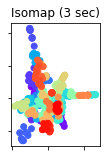

<Figure size 1080x360 with 0 Axes>

In [26]:
from fcps_run import execute_algo, add_subplot

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy import io
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import manifold
from statistics import mean, stdev
from functools import partial

from time import time  


nmi = normalized_mutual_info_score
ari = adjusted_rand_score

#####################
### USPS & MNIST ###
# ae_step = 5
# l_reg = 20.0
#####################

ae_step = 5
l_reg = 1.0
#epoch = 5000 // ae_step
epoch = 250
ae_lle_verbose = False
save_res = True
train_both = True


todo = ["USPS"]
todo = ["MNIST"]
todo = ["ORL"]
#todo = ["COIL-20"]
all_files = [i for i in datasets]

mode = 2
it = 10

subplot_row = 1
subplot_col = 8


def run_kMeans(X, y, name, algo=1):
    if algo == 1:
      kmeans = KMeans(n_clusters=len(np.unique(y)), n_init=20, max_iter=300)
      kmeans.fit(X)
      label = kmeans.labels_
    elif algo == 2:
      gmm = GaussianMixture(n_components=len(np.unique(y)), n_init=20, max_iter=300)
      label = gmm.fit_predict(X)
    res_nmi = nmi(label, y)
    res_ari = ari(label, y)      
    print(name)    
    print(res_nmi)
    print(res_ari)
    return res_nmi, res_ari


for myfile in all_files:
    if mode >= 2 and myfile not in todo: continue
    
    print("#####################")
    print("#",myfile)
    print("#####################")
    X, y, _, _ = datasets[myfile]
    
    gmm_nmis, gmm_aris, lle_nmis, lle_aris, ae_nmis, ae_aris, ae_lle_e_nmis, ae_lle_e_aris, ae_lle_l_nmis, ae_lle_l_aris = [], [], [], [], [], [], [], [], [], []
    lap_nmis, lap_aris = [], []
    best_mean_nmi, best_mean_ari = 0, 0
    for i in range(it):
        print("_________________________________________________________________")
        print(i, " \ ", it)
        temp = open(path+"/Results2/temp.txt", "w")
        temp.write(str(i))
        temp.close()

        subplot_cpt = 1
      
        fig = plt.figure(figsize=(15, 5))    

        # Parameters
        _, _, _, _, _, encoding_dim, _ = make_conv_autoencoder_parameters(X.shape[1], X.shape[2])
        print("encoding_dim = ", encoding_dim)                 

        #X_lap = execute_algo(partial(manifold.SpectralEmbedding, n_components=encoding_dim), X.reshape((X.shape[0], X.shape[1]*X.shape[2])), "Laplacian Eigenmap", subplot_cpt, y, fig)
        X_iso = execute_algo(partial(manifold.Isomap, n_components=encoding_dim), X.reshape((X.shape[0], X.shape[1]*X.shape[2])), "Isomap", subplot_cpt, y, fig)

        #####################    
        # k-Means
        #####################    
        # kMeans on Isomap
        res_nmi, res_ari = run_kMeans(X_iso, y.ravel(), "LAP")
        lap_nmis.append(res_nmi)
        lap_aris.append(res_ari)

        # Save results
        if save_res:   
            file_name = path+"/Results2/"+myfile+"_iso_res"

            res_file = open(file_name+"_nmi.txt", "a")
            towrite = str(lap_nmis[-1])+"\n"
            res_file.write(towrite)
            res_file.close()
            
            res_file = open(file_name+"_ari.txt", "a")
            towrite = str(lap_aris[-1])+"\n"
            res_file.write(towrite)
            res_file.close()    

"""
towrite = str(mean(lle_nmis))+","+str(stdev(lle_nmis))+","
towrite += str(mean(ae_nmis))+","+str(stdev(ae_nmis))+","+str(mean(ae_lle_e_nmis))+","+str(stdev(ae_lle_e_nmis))+","
towrite += str(mean(ae_lle_l_nmis))+","+str(stdev(ae_lle_l_nmis))+"\n"
res_file.write(towrite)
towrite = str(mean(lle_aris))+","+str(stdev(lle_aris))+","
towrite += str(mean(ae_aris))+","+str(stdev(ae_aris))+","+str(mean(ae_lle_e_aris))+","+str(stdev(ae_lle_e_aris))+","
towrite += str(mean(ae_lle_l_aris))+","+str(stdev(ae_lle_l_aris))
res_file.write(towrite)    
"""
